In [17]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels as sm
from statsmodels.stats.multitest import fdrcorrection  # Benjamini-Hochberg as default
from functools import partial
# %matplotlib inline
pd.options.display.max_columns = None
def increase_figsize(N, plt=plt):
    params = plt.gcf() if type(plt) is type(pd) else plt
    axes = params.get_axes()
    plSize = params.get_size_inches()
    params.set_size_inches((plSize[0]*N, plSize[1]*N))
def increase_size_by(N, fontsize, plt=plt):
    params = plt.gcf() if type(plt) is type(pd) else plt
    axes = params.get_axes()
    plSize = params.get_size_inches()
    params.set_size_inches((plSize[0]*N, plSize[1]*N))
    for ax in axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
            
# Setting some default params. 
cbf = ['#377eb8', '#ff7f00', '#4daf4a',
        '#f781bf', '#a65628', '#984ea3',
        '#999999', '#e41a1c', '#dede00']
cbf_map = mpl.colors.ListedColormap(cbf)
rc = {'axes.facecolor': 'white', 'axes.edgecolor': '.15', 'axes.axisbelow': True, 'figure.facecolor': 'white',
      'axes.labelcolor': '.15',  'text.color': '.25',
      'patch.force_edgecolor': True, 'patch.edgecolor': 'w',
      'xtick.bottom': True, 'ytick.left': True, 'xtick.color': '.15', 'ytick.color': '.15',
      'grid.linestyle': '-', 'axes.grid': False, 'grid.color': '.8', 
      'font.size': 30, 
      'xtick.labelsize': 15, 'ytick.labelsize': 15, 
      'axes.titlesize': 22,
      'axes.labelsize': 15,
      'legend.fontsize': 18, 'legend.title_fontsize': 30,
      }
sns.set(rc=rc)
sns.set_palette(cbf)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [20]:
def percentage(x): 
    return x / x.sum()

from pandas.core.base import PandasObject

PandasObject.set_columns = lambda df, values: df.T.set_index(values).T

pd.set_option('display.max_colwidth', 200)

In [4]:
has_header = True  # this can be made with the preprocessing file 'patches/remove_double_genomes.py' or 'patches/summary'
data_folder = '/home/hielke/bep/res/'
fig_folder = '/home/hielke/bep/figs/FOR_PUB/'
first_order = 'A'
second_order = 0
save = False
title_mod = ""
def save_fig(ax=None, save=save, plt=plt, title=None):
    if not save: 
        return 
    
    if not ax: 
        ax = plt.gca()
        
    title = title or (g.fig._suptitle._text 
                      if type(ax) is sns.axisgrid.FacetGrid 
                      else ax.get_title())
    
    global second_order
    second_order += 1
    
    dest = fig_folder + first_order + str(second_order) + "___" \
        + title.replace(" ", "_") + ".png"
    plt.savefig(dest, format='png', bbox_inches='tight')
    print("figure saved in " + dest)

# READ IN DATA

In [5]:
if has_header:
    df = pd.read_csv(data_folder + 'hits.tsv.header.csv', sep='\t', 
                    index_col=False, keep_default_na=False, 
                     dtype={'genome_id': str, 'spacer_pos': int, 'spacer_size': int}
                    ).set_index('genome_id')
else:
    df = pd.read_csv(data_folder + 'gene.matched.tsv.smallarraycheck.csv', sep='\t', 
                 names=['genome_key', 'genome_id', 'contig_hit', 'c_1', 'c_2', 'spacer_id', 'hit_ident', 'spacer_size', 
                        'contig_size', '3_prime', '5_prime', 'array_id', 'array_size', 'array_confid', 'repeat_size', 'array_type', 'genome_type',
                        'PAM_confid', 'poss_PAM', 'PAM_side', 'phage_class', 'with_phage',  'gene_hit', 'gene_id', 'gene_class'],
                index_col=False, keep_default_na=False, 
                     dtype={'genome_id': str}).set_index('genome_id')
df.drop(['3_prime', '5_prime', 'genome_key',], axis=1, inplace=True)
df.head()

,contig_hit,c_1,c_2,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,spacer_pos,rel_spacer_pos,name_spacer_pos
genome_id,,,,,,,,,,,,,,,,,,,,,,,,
100053.4,JQGS01000037,11782,11751,JQGS01000065_1_1,100.00,32,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTGCTAAAG,3,2,2,RNA+,JQGS01000037_19,UNKNOWN,1,0.000000,leader
100053.4,JQGS01000037,13121,13089,JQGS01000134_1_4,100.00,33,53765,JQGS01000134_1,5,3.02,28,NA,CAS-TypeIE,2,AGGAACTCAT,3,2,2,RNA+,JQGS01000037_20,UNKNOWN,4,0.750000,middle
100053.4,JQGS01000037,1789,1757,JQGS01000065_1_2,100.00,33,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTGAATCCG,3,2,2,INTERGENIC,NULL,NULL,2,0.090909,middle
100053.4,JQGS01000037,22144,22112,JQGS01000134_1_5,96.97,33,53765,JQGS01000134_1,5,3.02,28,NA,CAS-TypeIE,0,ATTTCGAGGT,3,2,2,RNA-,JQGS01000037_36,UNCLASSIFIED,5,1.000000,tail
100053.4,JQGS01000037,24519,24550,JQGS01000065_1_12,100.00,32,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTCGAATTC,3,2,2,RNA+,JQGS01000037_38,UNCLASSIFIED,12,1.000000,tail


In [6]:
ident = 90
df_sel = df.query('hit_ident > @ident and gene_id != "NULL"')
dfgenehits = df_sel.groupby([df_sel.index, 'gene_id']).nth(0)
    
if False:
    with open(data_folder + 'selection_for_gene_classification', 'w') as f:
        f.writelines(line + '\n' for line in set(df_sel.index))

In [7]:
# PERFORM SELECTION AS FOLLOWS:
# (NB: Slashes look like pipes when in italics, but are still slashes to indicate tabs.)
# alias mtawk="mawk -F '\t' -v OFS='\t'"
# mtawk 'FNR==NR{hits[$0]=1;next;} $1 in hits' selection_for_gene_classification gene_classification > gene_classification.sel
dfgenes = pd.read_csv(data_folder + 'gene_classification.sel.%d' % ident, sep='\t', 
                      names=['genome_id', 'gene_id', 's', 'e', 'side', 'gene_class'],
                      dtype={'genome_id': str}).set_index('genome_id')

In [8]:
gene_classes = dfgenes['gene_class'].value_counts()
all_genes = sum(gene_classes)

In [9]:
dfgenehits = df_sel.reset_index().groupby(['genome_id', 'gene_id']).first().reset_index().set_index('genome_id')

In [16]:
dfgenehits.head()

,gene_id,contig_hit,c_1,c_2,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_class,spacer_pos,rel_spacer_pos,name_spacer_pos
genome_id,,,,,,,,,,,,,,,,,,,,,,,,
100053.4,JQGS01000037_11,JQGS01000037,6382,6413,JQGS01000093_1_15,100.00,32,53765,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CTTAATTCCA,3,2,2,RNA+,Phosphoribosyltransferase domain,15,0.636364,middle
100053.4,JQGS01000037_19,JQGS01000037,11782,11751,JQGS01000065_1_1,100.00,32,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTGCTAAAG,3,2,2,RNA+,UNKNOWN,1,0.000000,leader
100053.4,JQGS01000037_20,JQGS01000037,13121,13089,JQGS01000134_1_4,100.00,33,53765,JQGS01000134_1,5,3.02,28,NA,CAS-TypeIE,2,AGGAACTCAT,3,2,2,RNA+,UNKNOWN,4,0.750000,middle
100053.4,JQGS01000037_36,JQGS01000037,22144,22112,JQGS01000134_1_5,96.97,33,53765,JQGS01000134_1,5,3.02,28,NA,CAS-TypeIE,0,ATTTCGAGGT,3,2,2,RNA-,UNCLASSIFIED,5,1.000000,tail
100053.4,JQGS01000037_38,JQGS01000037,24519,24550,JQGS01000065_1_12,100.00,32,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTCGAATTC,3,2,2,RNA+,UNCLASSIFIED,12,1.000000,tail


In [18]:
def binom_test(x, alternative):
    
    gene_name = x['index']
    all_genes = gene_classes[gene_name]
    genes_hit = x['gene_class']
    
    # We test if for a gene, the amount of genes that are hit is greater than expected.
    p = stats.binom_test(genes_hit, all_genes, expected_ratio, alternative=alternative)
    return p, gene_name


def fisher_exact(x, alternative):
    
    gene_name = x['index']
    all_this_gene = gene_classes[gene_name]
    genes_hit = x['gene_class']
    
    this_gene_not_hit = all_this_gene - genes_hit
    other_genes_hit = all_gene_hits - genes_hit
    other_genes_not_hit = not_hit_genes - this_gene_not_hit
    
    table = [[genes_hit, this_gene_not_hit], [other_genes_hit, other_genes_not_hit]]
    
    odds_ratio, p = stats.fisher_exact(table, alternative=alternative)
    return p, gene_name


def gene_test(dfgenehits, alternative, plot=False):
    # GENE ENRICHEMENT
    # UNIQUE GENES
    gene_class_hits = dfgenehits['gene_class'].value_counts()
    all_gene_hits = sum(gene_class_hits)

    expected_ratio = all_gene_hits / all_genes
    not_hit_genes = all_genes - all_gene_hits
    
    test = partial(fisher_exact, alternative=alternative)

    p_vals = gene_class_hits.reset_index().apply(test, result_type='expand', axis=1)
    
    if plot:
        p_vals[0].plot.hist(bins=20)
        plt.title("p-value histogram")
    
    # perform fdrcorrection
    
    p_corr = (
        # perform multiple testing correction.
        p_vals[fdrcorrection(p_vals[0])[0]].rename(columns={0: 'p', 1: 'gene'}) 
        # merge with information about the total count of genes that are hit.
        .merge(
            gene_class_hits.to_frame('count').reset_index().rename(columns={'index': 'gene'}), 
            how='left', 
            on='gene',
        # merge with total count of all genes.
        ).merge(
            gene_classes.to_frame('total_count').reset_index().rename(columns={'index': 'gene'})
    ))
    
    return p_corr

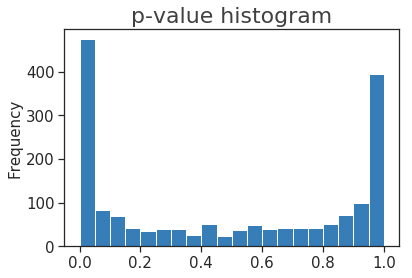

In [21]:
# Change the alternative hypothesis to test to see what genes have more or less than expected STSs (greater / less).
alternative = 'greater'
p_corr_greater = gene_test(dfgenehits, alternative, plot=True)

In [38]:
# p_corr_greater.query('count >= 0').sort_values(by='count', ascending=False)

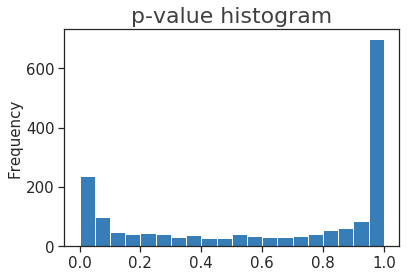

In [23]:
alternative = 'less'
p_corr_less = gene_test(dfgenehits, alternative, plot=True)

In [59]:
# p_corr_less.query('count >= 0').sort_values(by='total_count', ascending=False)

## Perform test for types individually

In [25]:
df_genome_class = pd.read_csv(data_folder + 'genome.types.csv', sep='\t', 
                              names=['genome_id', 'type', 'class', 'num_genes'], 
                              dtype={'genome_id': str, 'num_genes': int}).set_index('genome_id')
df_genome_class.head()

,type,class,num_genes
genome_id,,,
100053.4,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11
100053.5,CAS-TypeIE,SingleUnknownExtra,8
100053.6,CAS-TypeIE,SingleUnknownExtra,8
100053.7,CAS-TypeIE,SingleUnknownExtra,8
100053.8,CAS-TypeIE,AccompaniedSingleUnknown,8


# Top level plotting (Of STS in groups "No CAS genes", "Incomplete", "Mixed CRISPR System", "Complete CRISPR System")
Plots that make use of grouping of genomes in the large (top level) distinctions.

In [26]:
# Naming used for the groupings.

NOCAS = "No CAS genes"
Mixed = "Mixed CRISPR System"
Complete = "Complete CRISPR System"
Incomplete = "Incomplete CRISPR System"
other = 'Cas-TypeVC | CAS-TypeVIB2'  # 'other'  # Those that exist in all, but not anymore in the selfhit group.
# 'CAS-TypeVC': 1, 'CAS-TypeVIB2': 2

#### First we make a `new_type_group`

In [27]:
def new_type_group(row):
#     print(row)
    if row['num_genes'] == 0:
        return NOCAS
    if "Unclassified" in row['class']:
        return Incomplete
    if "MultipleConfirmed" in row['class']:
        # Confirmed Mixed: The CRISPR array associated confirms that the type is a mixed type.
        return Mixed  
    if "/" in row['type'] or row['type'] == "CAS": 
        return Mixed
    return row['type']
#     if "Confirmed" in row['class']:
#         return "Confirmed " + row['type']
#     if "Accompanied" in row['class']:
#         return "Accompanied " + row['type']
    
df_genome_class['new_type_group'] = df_genome_class.apply(new_type_group, axis=1)

In [28]:
df = df.join(df_genome_class)
df_genome_class[['new_type_group']].head()

,new_type_group
genome_id,
100053.4,CAS-TypeIE
100053.5,CAS-TypeIE
100053.6,CAS-TypeIE
100053.7,CAS-TypeIE
100053.8,CAS-TypeIE


In [41]:
dfgenehits_typed = dfgenehits.join(df_genome_class[['new_type_group']])

In [64]:
from IPython.display import display, HTML

def print_test_results(part, save=False):
    
    alternative='greater'
    p_val = gene_test(part, alternative)
    if not p_val.empty:
        res = p_val.query('count >= 0').sort_values(by='count', ascending=False)
        crispr_type = part['new_type_group'].iloc[0]
        if save:
            res.to_csv('/home/hielke/bep/out/gene_enrichement/' + crispr_type + '_' + alternative + '.csv', sep='\t', index=False)
        else:
            print(crispr_type, len(part))
            display(HTML(res.to_html()))
    
save_test_results = partial(print_test_results, save=True)
dfgenehits_typed.groupby(by='new_type_group').apply(save_test_results)

""
